[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [4]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching mahabharat?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about mahabharat. But what other wars should I learn about?", name="Balram"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching mahabharat?
================================ Human Message =================================
Name: Balram

Yes, I know about mahabharat. But what other wars should I learn about?


Recall we can pass them to a chat model.

In [5]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm.invoke(messages)

AIMessage(content='If you\'re interested in learning about significant historical wars beyond the Mahabharata, here are a few you might find intriguing:\n\n1. **Trojan War**: An ancient conflict from Greek mythology, primarily known through Homer\'s "Iliad." It involved the Greeks and the city of Troy and is famous for its characters like Achilles and Hector.\n\n2. **Persian Wars**: A series of conflicts between the Greek city-states and the Persian Empire during the 5th century BCE, notable battles include Marathon, Thermopylae, and Salamis.\n\n3. **Peloponnesian War**: A protracted and destructive conflict between Athens and Sparta, along with their respective allies, in ancient Greece.\n\n4. **Punic Wars**: A series of three wars fought between Rome and Carthage, including the famous Hannibal and his crossing of the Alps with elephants in the Second Punic War.\n\n5. **Hundred Years\' War**: A series of conflicts waged from 1337 to 1453 between England and France over territorial cla

We can run our chat model in a simple graph with `MessagesState`.

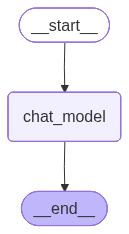

In [6]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching mahabharat?
================================ Human Message =================================
Name: Balram

Yes, I know about mahabharat. But what other wars should I learn about?
================================== Ai Message ==================================

If you're interested in significant wars throughout history, here are some major ones you might explore:

1. **The Trojan War** - A legendary conflict in Greek mythology between the city of Troy and the Greeks, sparked by the abduction of Helen.

2. **The Peloponnesian War** - Fought between the Athenian Empire and Sparta, along with their respective allies in ancient Greece.

3. **The Punic Wars** - A series of three wars between Rome and Carthage that marked an era of Roman dominance over the Mediterranean.

4. **The Hundred Years' War** - A series of conflicts waged from 1337 to 1453 between the Kingdom 

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

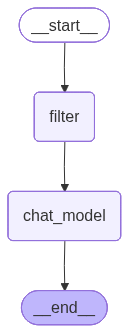

In [8]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Balram", id="2"))
messages.append(AIMessage("So you said you were researching mahabharat?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about mahabharat. But what others should I learn about?", name="Balram", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching mahabharat?
================================ Human Message =================================
Name: Balram

Yes, I know about mahabharat. But what others should I learn about?
================================== Ai Message ==================================

Apart from the Mahabharata, there are several other significant texts and areas of study within Indian mythology and literature that you might find interesting:

1. **Ramayana**: Another major epic, attributed to the sage Valmiki. It tells the story of Lord Rama, his wife Sita, and his loyal companion Hanuman, battling the demon king Ravana.

2. **Upanishads**: Philosophical texts that form the basis of several key concepts in Hindu philosophy, discussing topics such as Brahman, Atman, and moksha.

3. **Bhagavad Gita**: A 700-verse Hindu scripture that is part of the Mahabharata, consisting of a conversation be

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

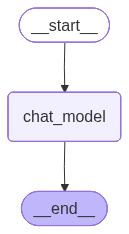

In [10]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [11]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Greeks!", name="Balram"))

In [12]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Balram

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching mahabharat?
================================ Human Message =================================
Name: Balram

Yes, I know about mahabharat. But what others should I learn about?
================================== Ai Message ==================================

Apart from the Mahabharata, there are several other significant texts and areas of study within Indian mythology and literature that you might find interesting:

1. **Ramayana**: Another major epic, attributed to the sage Valmiki. It tells the story of Lord Rama, his wife Sita, and his loyal companion Hanuman, battling the demon king Ravana.

2. **Upanishads**: Philosophical texts that form the basis of several key conc

In [13]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Balram

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching mahabharat?
================================ Human Message =================================
Name: Balram

Yes, I know about mahabharat. But what others should I learn about?
================================== Ai Message ==================================

Apart from the Mahabharata, there are several other significant texts and areas of study within Indian mythology and literature that you might find interesting:

1. **Ramayana**: Another major epic, attributed to the sage Valmiki. It tells the story of Lord Rama, his wife Sita, and his loyal companion Hanuman, battling the demon king Ravana.

2. **Upanishads**: Philosophical texts that form the basis of several key conc

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

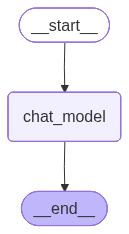

In [14]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Krishna lives!", name="Balram"))

In [16]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Krishna lives!', additional_kwargs={}, response_metadata={}, name='Balram')]

In [17]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r